In [36]:
import torch
import pytorch_lightning as pl

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule
from utils import load_state_dict

In [37]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

Files already downloaded and verified
Files already downloaded and verified


<font size="12">Target model visualization</font>

In [38]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title(classes[label])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [39]:
from collections import OrderedDict

target_model = t2t_vit_14(num_classes=10)

checkpoint = torch.load('../../checkpoint_cifar10_T2t_vit_14/ckpt_0.01_0.0005_97.23.pth')

new_state_dict = OrderedDict()

for k, v in checkpoint.items():
    # strip `module.` prefix
    name = k[7:] if k.startswith('module') else k
    new_state_dict[name] = v

state_dict = new_state_dict

target_model.load_state_dict(state_dict, strict=False)

target_model.eval()

# predict with the model
preds = target_model(images)
print(f'preds shape is {preds.shape}')
preds = torch.argmax(torch.nn.functional.softmax(preds[:,0], dim=1), dim=1)

adopt performer encoder for tokens-to-token
preds shape is torch.Size([32, 197, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


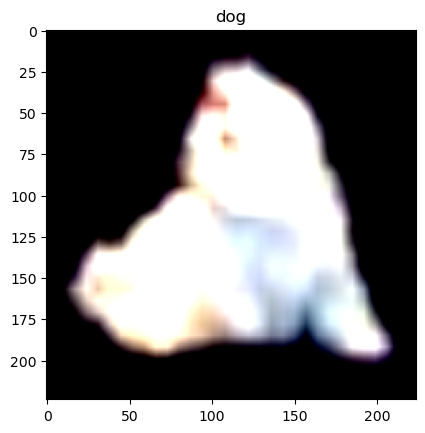

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


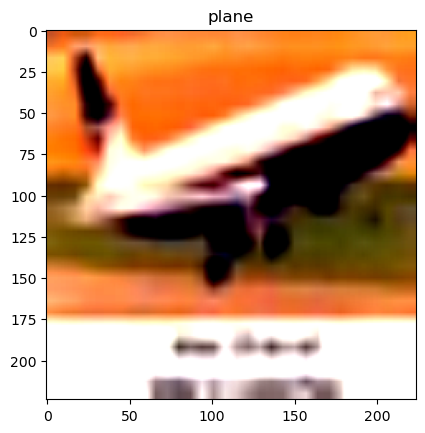

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


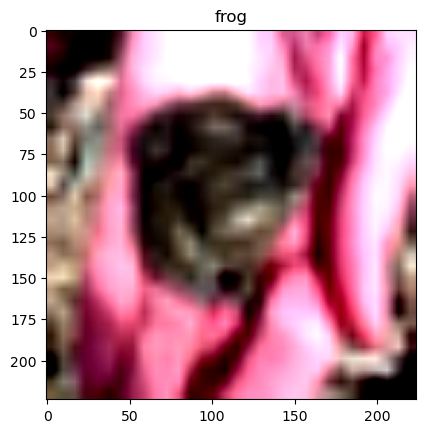

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


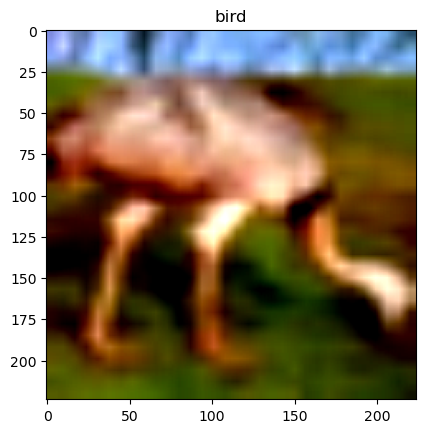

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


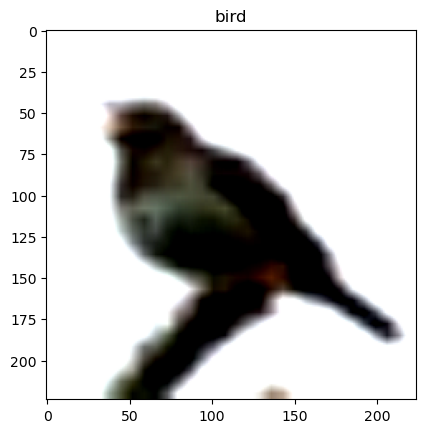

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


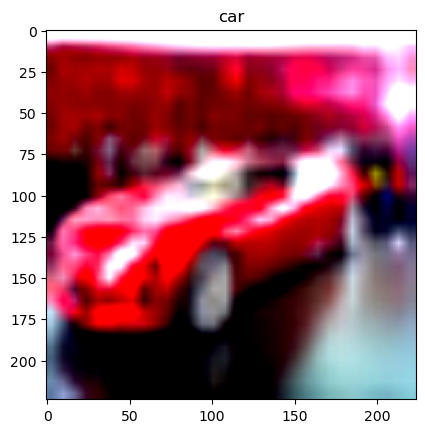

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


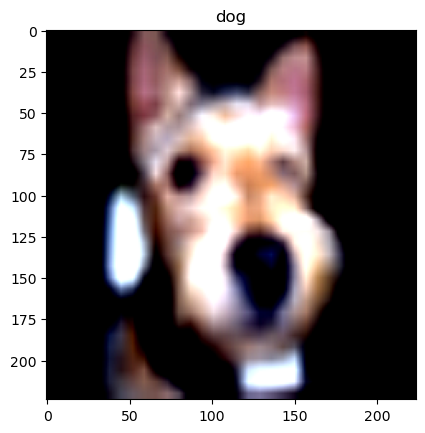

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


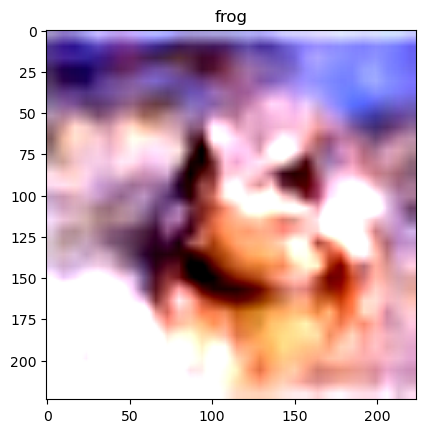

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


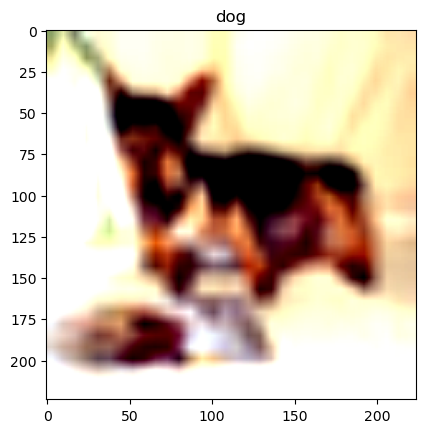

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


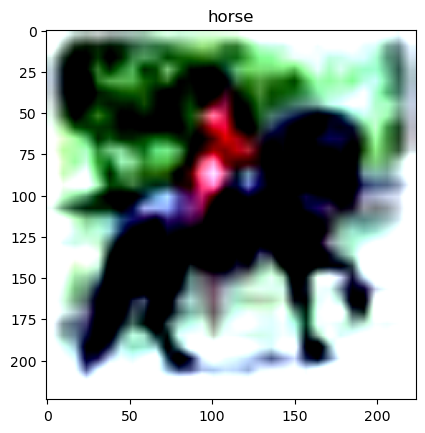

In [40]:
for i in range(10):
    imshow(images[i], preds[i])

<font size="12">Surrogate model visualization</font>

In [41]:
surrogate = Surrogate.load_from_checkpoint("checkpoints_surrogate/lightning_logs/version_0/checkpoints/epoch=49-step=70350.ckpt",
                                        output_dim=10,
                                        target_model=target_model,
                                        learning_rate=1e-5,
                                        weight_decay=0.0,
                                        decay_power='cosine',
                                        warmup_steps=2)

surrogate.eval()

# predict with the model
out = surrogate(images=images.cuda(), masks=masks.cuda())

adopt performer encoder for tokens-to-token


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


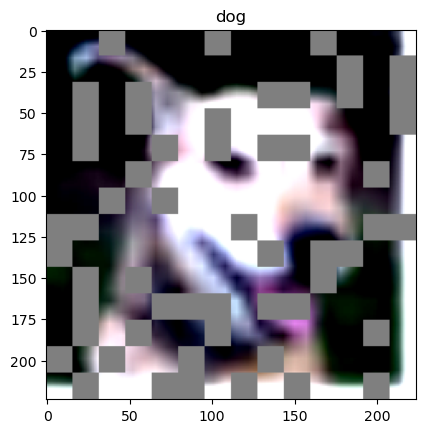

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


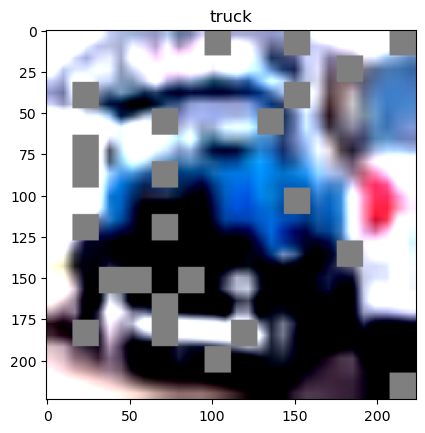

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


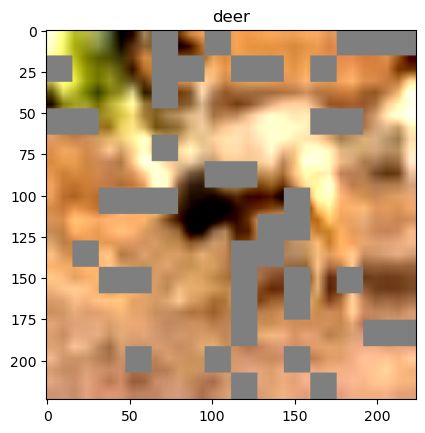

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


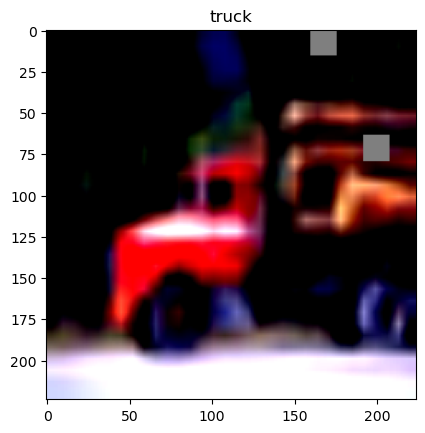

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


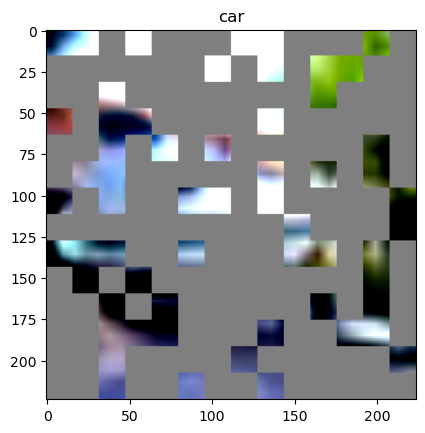

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


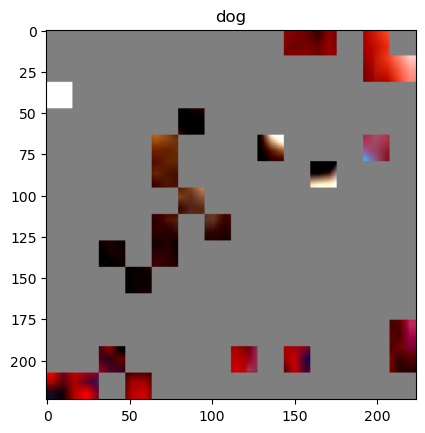

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


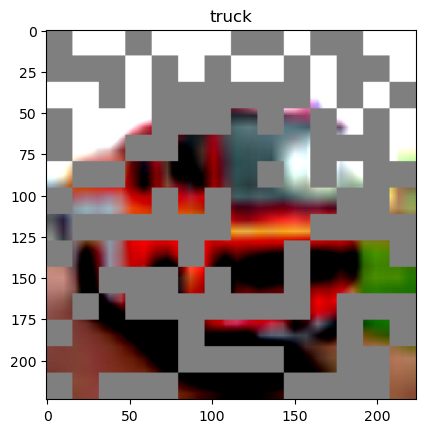

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


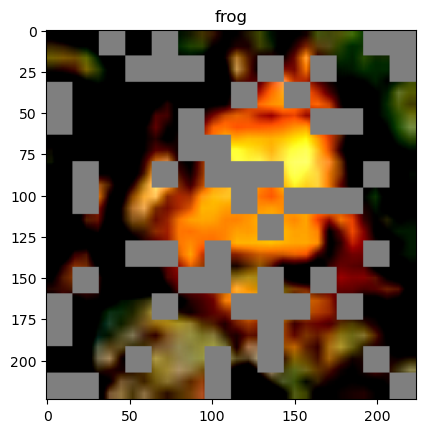

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


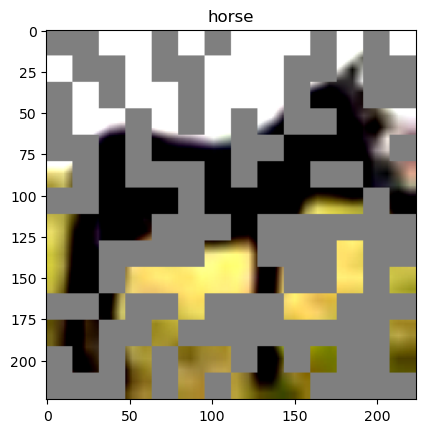

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


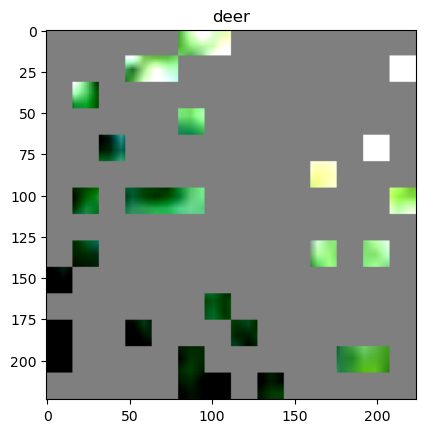

In [42]:
def get_masked(images, masks):
    masks_ = torch.repeat_interleave(torch.repeat_interleave(masks.reshape(-1, 14, 14), 16, dim=2), 16, dim=1)
    images_masked = images * masks_.unsqueeze(1)
    return images_masked

images_masked = get_masked(images, masks)
labels_pred = torch.argmax(torch.nn.functional.softmax(out.squeeze(), dim=1), dim=1)
for i in range(10, 20):
    imshow(images_masked[i], labels_pred[i])